<a href="https://colab.research.google.com/github/Siraj19/IPFSP/blob/main/ML_Course_Project_Scratchpad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instructions:** Just open it on Google Collab or as Juypter Notebook.

In [1]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path to your Excel file in Google Drive
file_path = '/content/drive/My Drive/ICreatedManually/ML_Course_Project/OGDCL_DATASET_V4.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Loading the excel file dataset
def load_excel_file(file_path):
    try:
        # Load Excel file
        xls = pd.ExcelFile(file_path)

        # Load each sheet into a dictionary
        data = {}
        for sheet_name in xls.sheet_names:
            data[sheet_name] = pd.read_excel(xls, sheet_name)

        return data

    except Exception as e:
        print("Error loading Excel file:", e)
        return None

In [3]:
# Load Excel file
loaded_data = load_excel_file(file_path)

In [4]:
# If data is loaded successfully, print it
if loaded_data is not None:
    for sheet_name, sheet_data in loaded_data.items():
        print(f"Sheet Name: {sheet_name}")
        print(sheet_data)

Sheet Name: Yearly_Financial_Statement
    Year        Equity        Assets   Liabilities  Current Assets  \
0   1999   33140000000   54489000000   21349000000     24133000000   
1   2000   41499000000   59218000000   17719000000     29291000000   
2   2001   51279000000   67762000000   16483000000     38121000000   
3   2002   57239568000   74875595000   17636027000     36677661000   
4   2003   64096779000   81815042000   17718263000     44039954000   
5   2004   83190000000  104940000000   21750000000     57870000000   
6   2005   90070000000  123280000000   33210000000     72710000000   
7   2006  101470000000  129210000000   27740000000     76820000000   
8   2007  106940000000  136750000000   29810000000     74920000000   
9   2008  110420000000  152310000000   41890000000     79820000000   
10  2009  126170000000  177990000000   51820000000     86830000000   
11  2010  114380000000  228870000000  114490000000    120430000000   
12  2011  158560000000  261780000000  103220000000 

In [5]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [6]:
# Function for dataset augmentation
def polynomial_interpolation(data, degree=4, num_points=10):
    interpolated_data = pd.DataFrame(index=np.arange(len(data) * num_points))  # Initialize DataFrame with new index
    for column in data.columns:
        x = np.arange(len(data))
        y = data[column].values
        valid = ~np.isnan(y)
        if valid.sum() > degree:  # Need at least degree+1 points to fit a polynomial
            # Fit a polynomial
            p = np.polyfit(x[valid], y[valid], degree)
            # Generate new x values within the range of existing points
            new_x = np.linspace(x.min(), x.max(), len(x) * num_points)
            # Evaluate the polynomial at the new x values within the existing range
            new_y = np.polyval(p, new_x)
            # Update the DataFrame with the new interpolated points
            interpolated_data[column] = new_y
        else:
            # Not enough points to fit a polynomial, copy the original data
            interpolated_data[column] = np.repeat(y, num_points)  # Repeat original values

    return interpolated_data

In [7]:
# Assuming loaded_data is a dictionary where keys are sheet names and values are Pandas DataFrames
# Assuming features_columns contains the names of the columns to be used as features
# Assuming label_column contains the name of the column to be used as label

# 1. Select the desired columns from your DataFrame
sheet_name1 = 'Yearly_Profit_Loss_Statement'
sheet_name2 = 'Yearly_Financial_Statement'

features_columns1 = ['Sales', 'Other Revenues', 'Earnings(Pre Tax)', 'Earnings(Post Tax)', 'Crude Oil (Thousand Barrels)', 'Gas (MMcf)', 'Payouts/Dividends', 'Payouts/Dividends Ratio', 'USD to PKR']
features_columns2 = ['Equity', 'Assets', 'Liabilities', 'Current Assets', 'Non-current Assets', 'Current Liabilities', 'Non Current Liabilities', 'ROE', 'ROA', 'Debt/Equity', 'Debt/Asset', 'SBP Policy Rate']

# Get the DataFrame for the specified sheet
df1 = loaded_data[sheet_name1]
df2 = loaded_data[sheet_name2]

# Select features
features1 = df1[features_columns1]
features2 = df2[features_columns2]

# Concatenate features along the appropriate axis
features = pd.concat([features1, features2], axis=1)

# Perform polynomial interpolation for feature augmentation
augmented_features = polynomial_interpolation(features, 6, 10)

# Normalize augmented features
maxs = augmented_features.max()
features_scale_factor = maxs
normalized_augmented_features = augmented_features.div(maxs)

In [8]:
# Just printing scale factor
print(maxs)

Sales                           2.492998e+11
Other Revenues                  3.165631e+10
Earnings(Pre Tax)               1.414761e+11
Earnings(Post Tax)              1.002880e+11
Crude Oil (Thousand Barrels)    1.488322e+04
Gas (MMcf)                      3.996102e+05
Payouts/Dividends               3.856038e+10
Payouts/Dividends Ratio         9.177209e-01
USD to PKR                      1.666601e+02
Equity                          7.757918e+11
Assets                          9.755886e+11
Liabilities                     1.997968e+11
Current Assets                  6.482371e+11
Non-current Assets              3.262181e+11
Current Liabilities             1.052822e+11
Non Current Liabilities         8.847553e+10
ROE                             4.751343e-01
ROA                             3.105258e-01
Debt/Equity                     6.247469e-01
Debt/Asset                      3.778625e-01
SBP Policy Rate                 1.390824e-01
dtype: float64


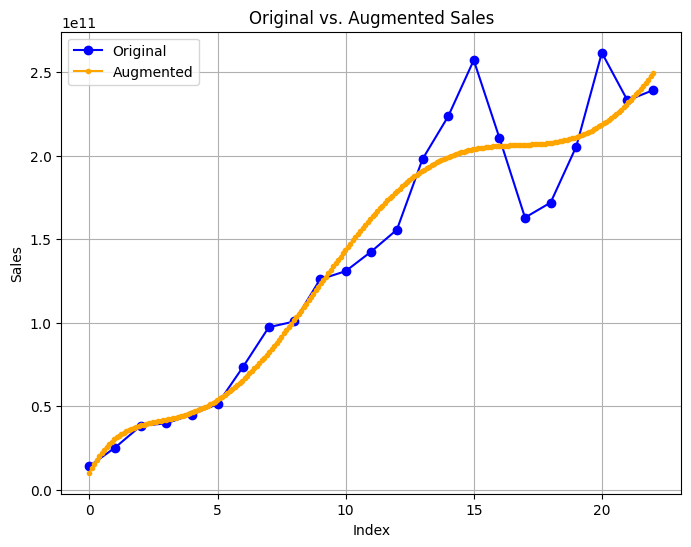

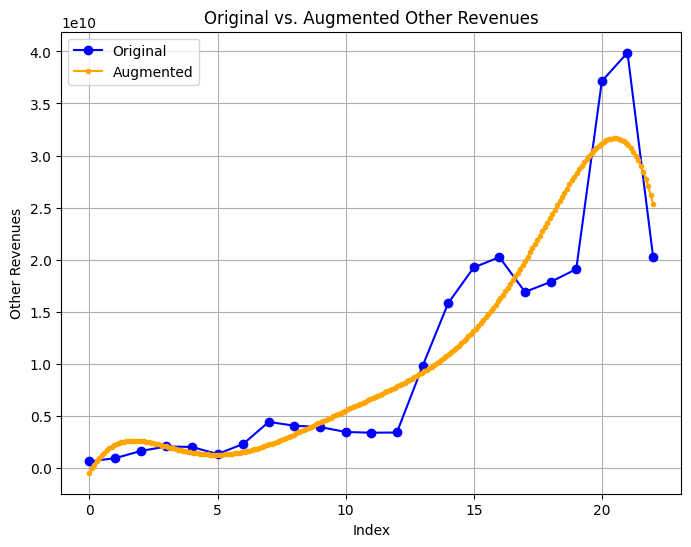

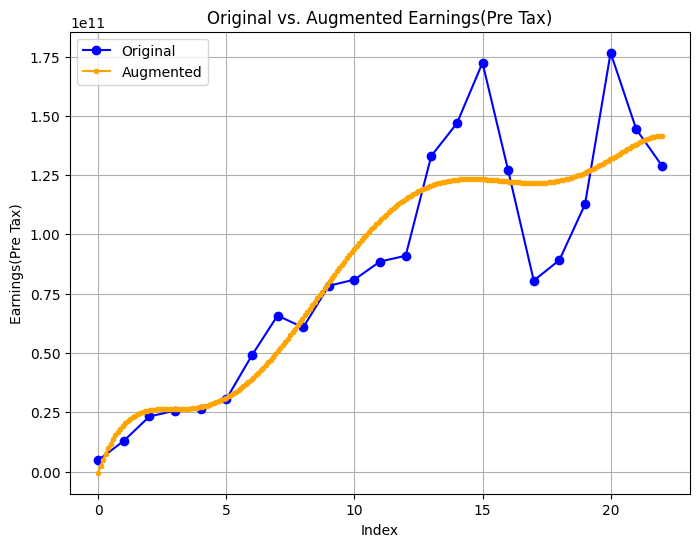

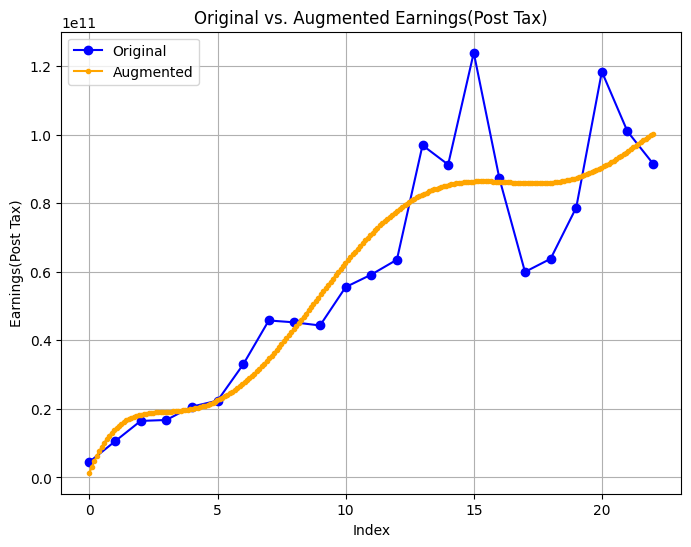

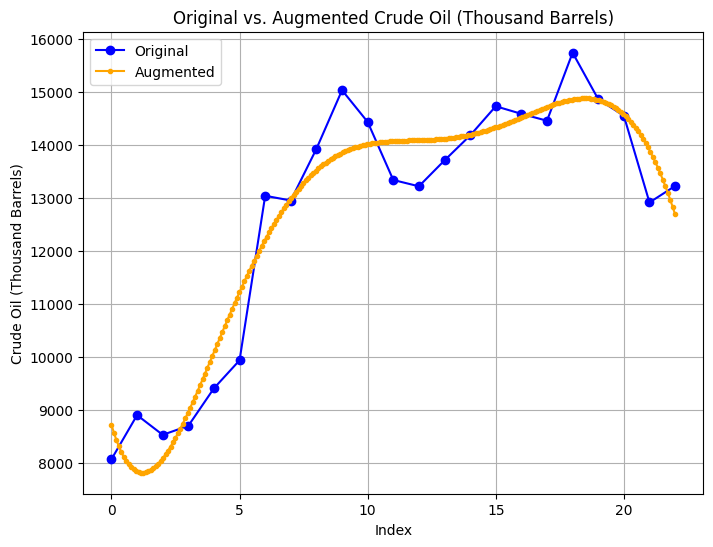

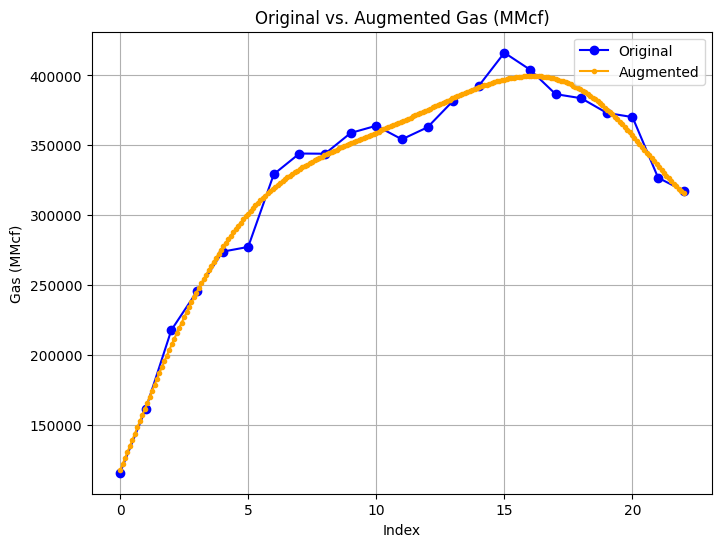

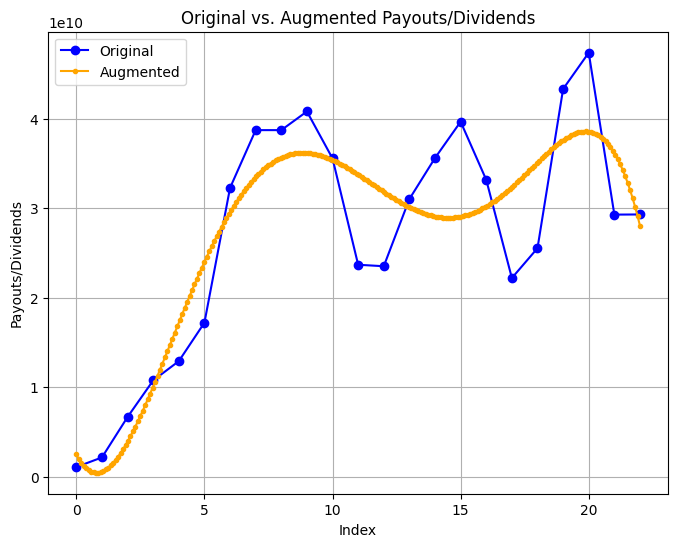

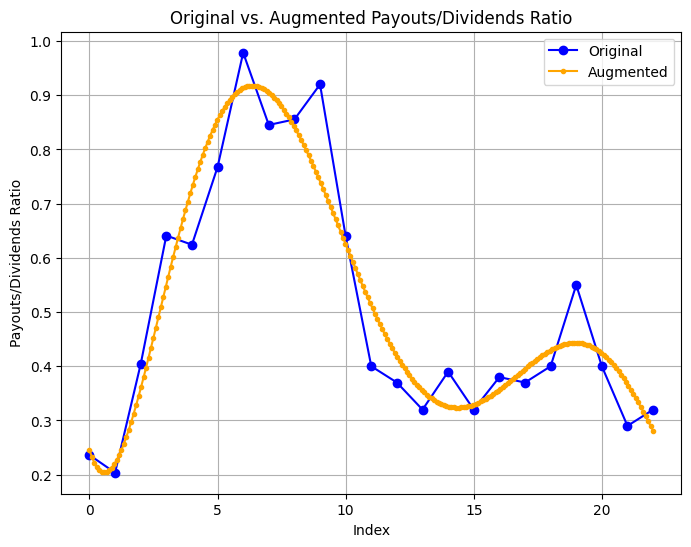

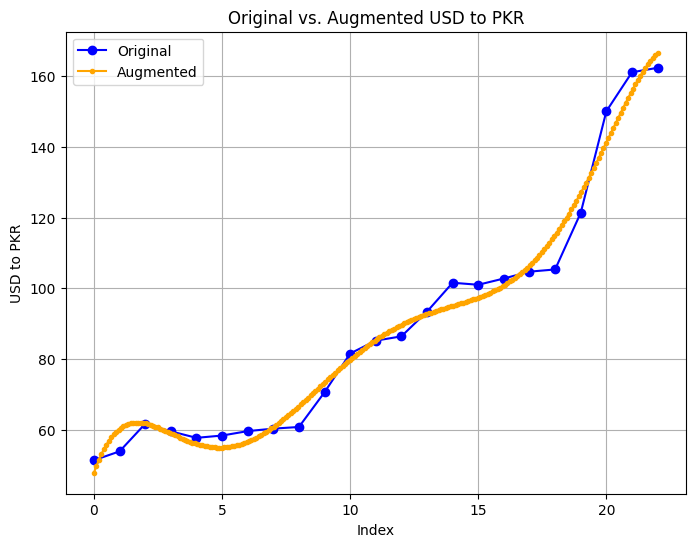

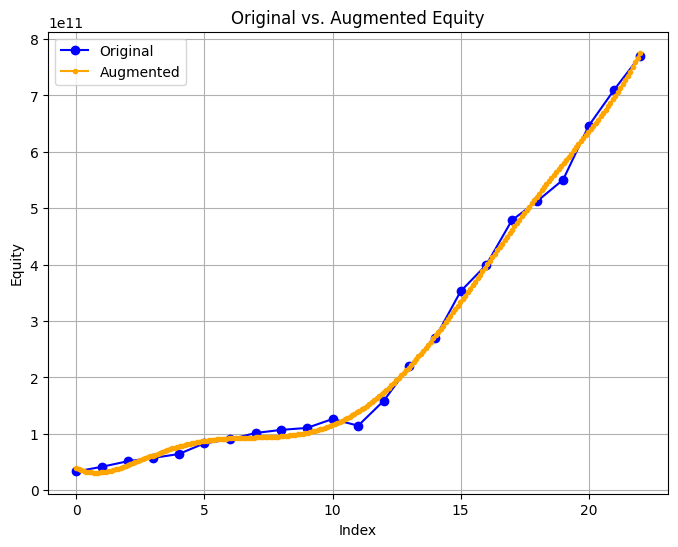

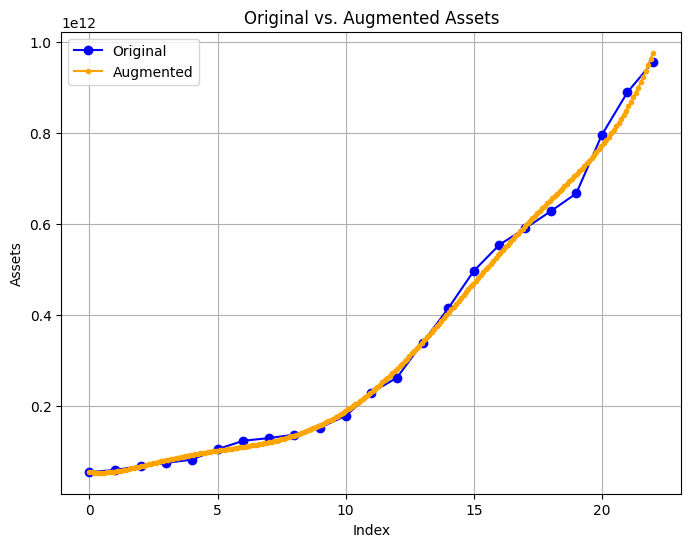

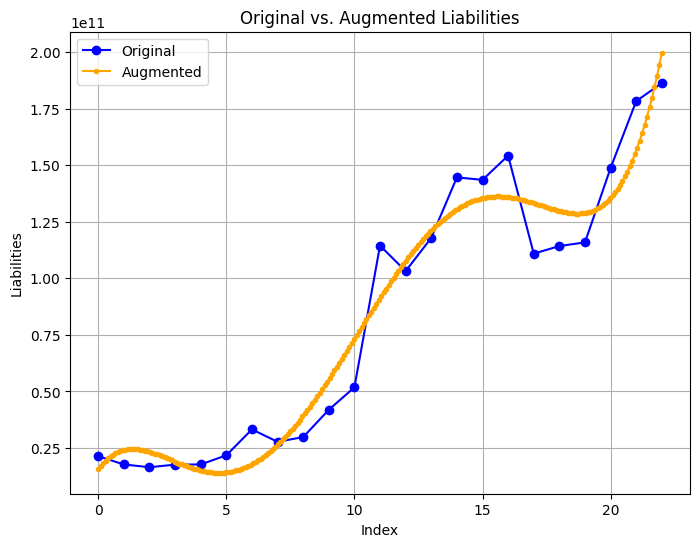

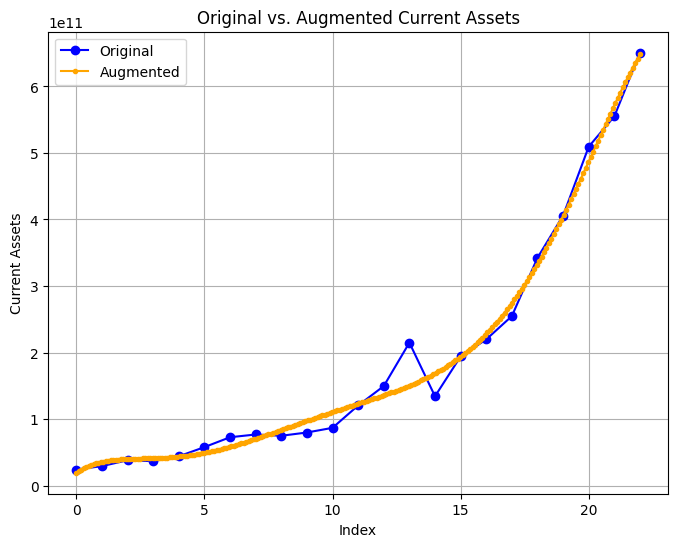

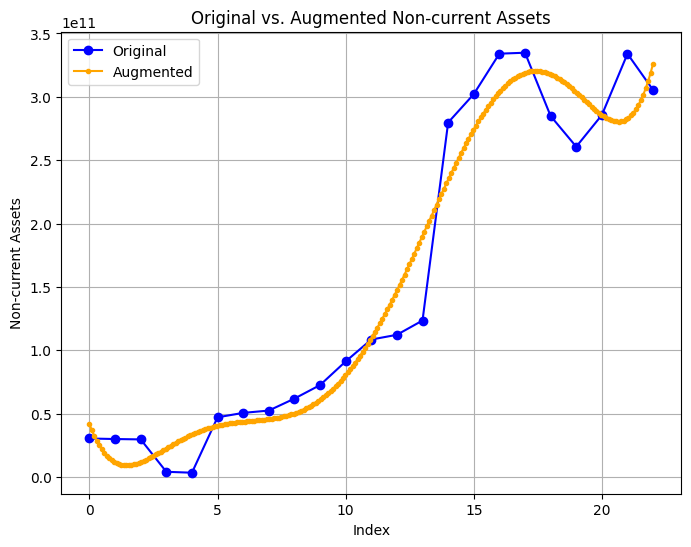

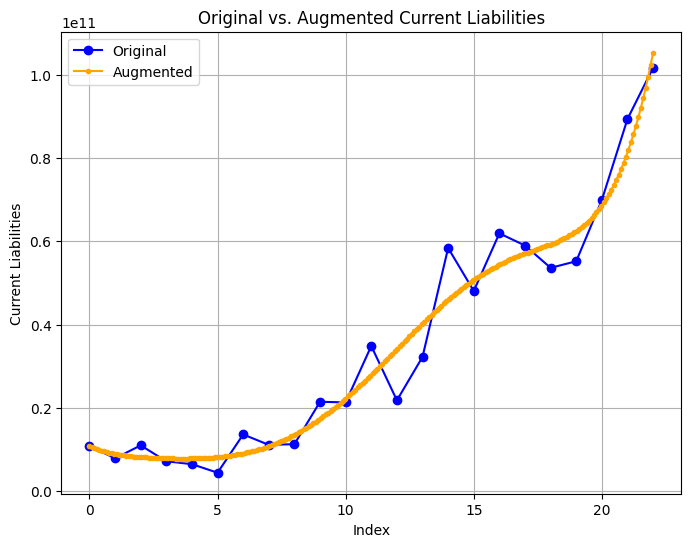

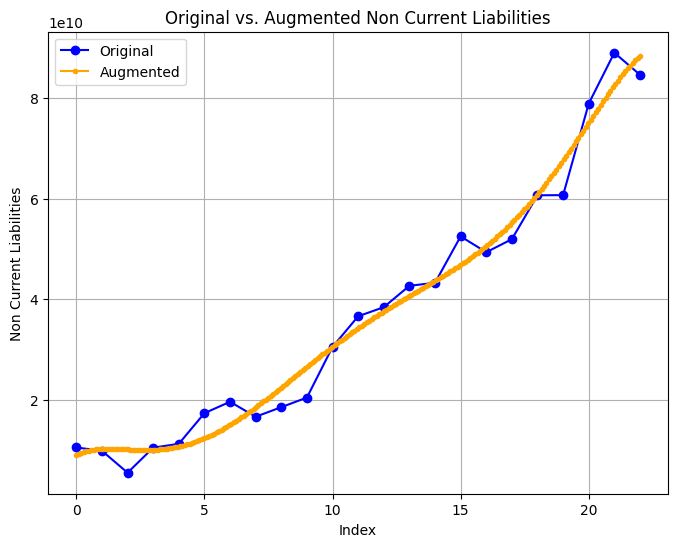

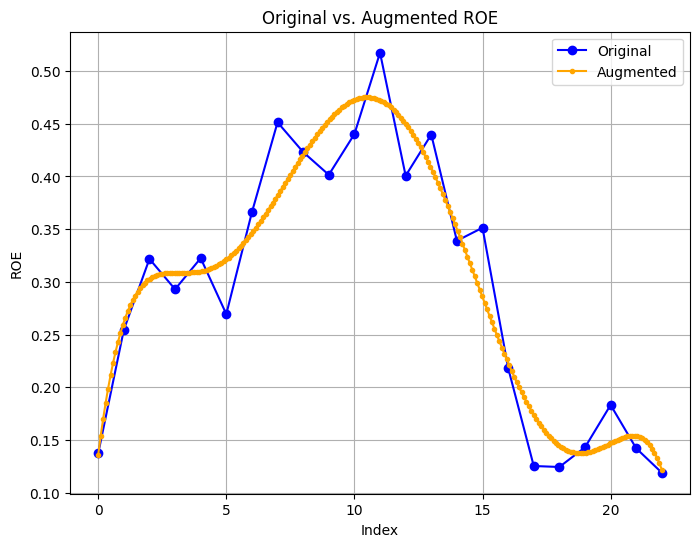

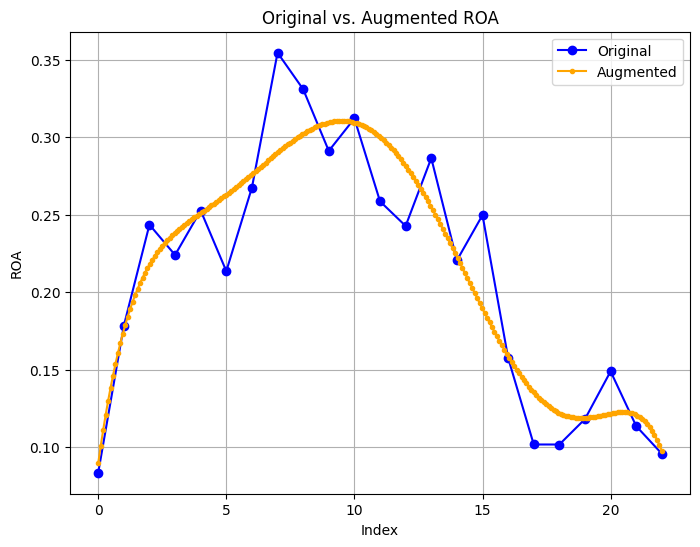

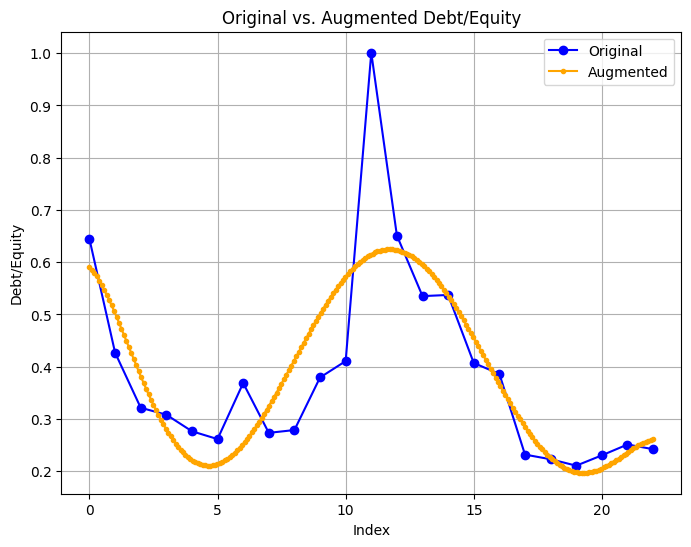

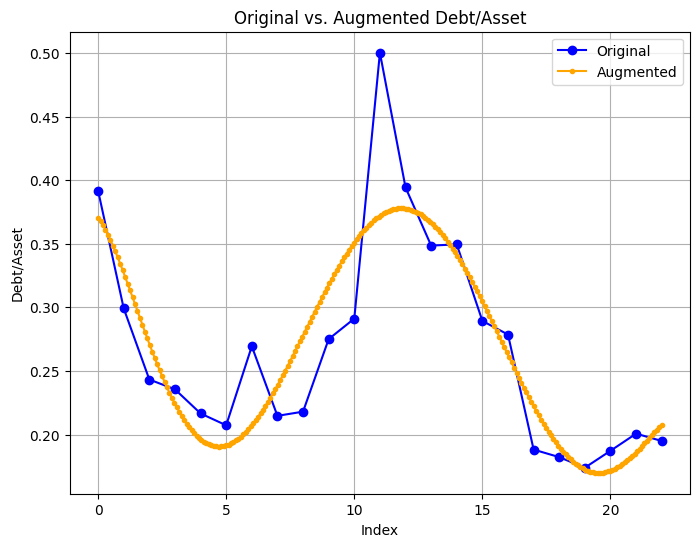

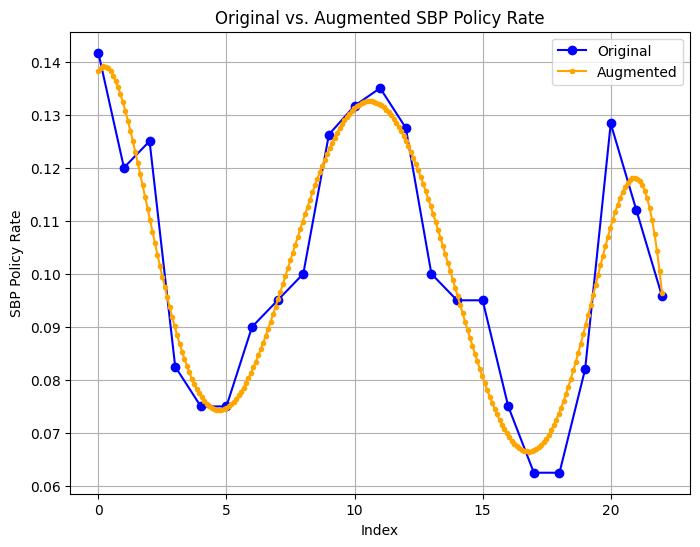

In [9]:
# Upsample both original and augmented features
upsampled_index = np.linspace(features.index.min(), features.index.max(), len(features) * 10)

# Loop through each feature and plot separately
for column in features.columns:
    # Create a new figure for each feature
    plt.figure(figsize=(8, 6))

    # Plot original feature
    plt.plot(features.index, features[column], label='Original', linestyle='-', marker='o', color='blue')

    # Plot augmented feature
    plt.plot(upsampled_index, augmented_features[column], label='Augmented', linestyle='-', marker='.', color='orange')

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.title(f'Original vs. Augmented {column}')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()


In [10]:
print(augmented_features)

            Sales  Other Revenues  Earnings(Pre Tax)  Earnings(Post Tax)  \
0    1.027014e+10   -4.858755e+08      -5.000995e+08        1.384453e+09   
1    1.306424e+10   -7.474050e+07       2.400201e+09        3.161891e+09   
2    1.564991e+10    2.979801e+08       5.063747e+09        4.801369e+09   
3    1.803878e+10    6.344676e+08       7.503706e+09        6.310327e+09   
4    2.024211e+10    9.368263e+08       9.732822e+09        7.695976e+09   
..            ...             ...                ...                 ...   
225  2.417201e+11    2.843497e+10       1.408779e+11        9.833396e+10   
226  2.435465e+11    2.777722e+10       1.411317e+11        9.883511e+10   
227  2.454195e+11    2.704473e+10       1.413204e+11        9.932935e+10   
228  2.473377e+11    2.623394e+10       1.414375e+11        9.981444e+10   
229  2.492998e+11    2.534118e+10       1.414761e+11        1.002880e+11   

     Crude Oil (Thousand Barrels)     Gas (MMcf)  Payouts/Dividends  \
0               

In [11]:
data = normalized_augmented_features.values

In [12]:
# Define window size and step size
window_size = 30  # Number of past observations to consider
step_size = 1     # Step size for sliding window
forecast_horizon = 10  # Number of steps to forecast into the future

# Prepare input sequences and target values for multi-step forecasting
X = []
y = []
for i in range(len(data) - window_size - forecast_horizon + 1):
    X.append(data[i:(i + window_size)])
    y.append(data[(i + window_size):(i + window_size + forecast_horizon)])
X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape y_train and y_test to match the output layer dimensions
y_train = y_train.reshape(-1, forecast_horizon * (len(features_columns1) + len(features_columns2)))
y_test = y_test.reshape(-1, forecast_horizon * (len(features_columns1) + len(features_columns2)))

In [13]:
print(X_train.shape)
print(y_train.shape)

(152, 30, 21)
(152, 210)


In [14]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

In [15]:
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM

# Define the RNN model with an additional Dense layer
model = Sequential([
    LSTM(units=64*4, input_shape=(window_size, len(features_columns1) + len(features_columns2))),
    Dense(units=32*4, activation='relu'),  # Additional Dense layer
    Dense(units=forecast_horizon * (len(features_columns1) + len(features_columns2))),  # Output layer with multiple forecasts
])


In [16]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [17]:
# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=500, batch_size=15, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/500
9/9 [==============================] - 5s 201ms/step - loss: 0.2668 - val_loss: 0.1922
Epoch 2/500
9/9 [==============================] - 1s 67ms/step - loss: 0.0961 - val_loss: 0.1006
Epoch 3/500
9/9 [==============================] - 1s 58ms/step - loss: 0.0310 - val_loss: 0.1012
Epoch 4/500
9/9 [==============================] - 1s 61ms/step - loss: 0.0193 - val_loss: 0.0855
Epoch 5/500
9/9 [==============================] - 1s 57ms/step - loss: 0.0136 - val_loss: 0.0696
Epoch 6/500
9/9 [==============================] - 1s 57ms/step - loss: 0.0100 - val_loss: 0.0516
Epoch 7/500
9/9 [==============================] - 1s 66ms/step - loss: 0.0068 - val_loss: 0.0407
Epoch 8/500
9/9 [==============================] - 1s 68ms/step - loss: 0.0041 - val_loss: 0.0398
Epoch 9/500
9/9 [==============================] - 1s 61ms/step - loss: 0.0029 - val_loss: 0.0346
Epoch 10/500
9/9 [==============================] - 1s 58ms/step - loss: 0.0024 - val_loss: 0.0296
Epoch 11/500
9/9 [

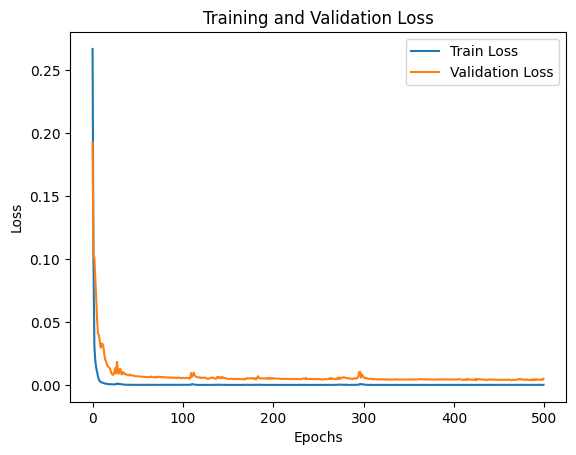

In [18]:
# Extract training and validation loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [19]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

2/2 [==============================] - 0s 17ms/step - loss: 0.0460
Test Loss: 0.0459822453558445


In [20]:
# Make predictions on the test data for the sake of plot
predictions_test = model.predict(X_test)
# Make predictions on the train data for the sake of plot
predictions_train = model.predict(X_train)

5/5 [==============================] - 0s 29ms/step


In [21]:
y_test_reshaped = y_test.reshape(y_test.shape[0], forecast_horizon, X.shape[2])
y_train_reshaped = y_train.reshape(y_train.shape[0], forecast_horizon, X.shape[2])

In [22]:
# Reshape the predictions to match the original shape of y_test
predictions_test = predictions_test.reshape(-1, forecast_horizon, len(features_columns1) + len(features_columns2))
# Reshape the predictions to match the original shape of y_train
predictions_train = predictions_train.reshape(-1, forecast_horizon, len(features_columns1) + len(features_columns2))

In [23]:
# Down sampling
y_test_downsampled = np.mean(y_test_reshaped, axis=1)
y_train_downsampled = np.mean(y_train_reshaped, axis=1)
predictions_train_downsampled = np.mean(predictions_train, axis=1)
predictions_test_downsampled = np.mean(predictions_test, axis=1)

In [24]:
print(y_test_downsampled.shape)
print(predictions_test_downsampled.shape)
print(y_train_downsampled.shape)
print(predictions_train_downsampled.shape)

(39, 21)
(39, 21)
(152, 21)
(152, 21)


In [25]:
#Scaling back
y_test_downsampled_scaled = y_test_downsampled*features_scale_factor.values
y_train_downsampled_scaled = y_train_downsampled*features_scale_factor.values
predictions_train_downsampled_scaled = predictions_train_downsampled*features_scale_factor.values
predictions_test_downsampled_scaled = predictions_test_downsampled*features_scale_factor.values

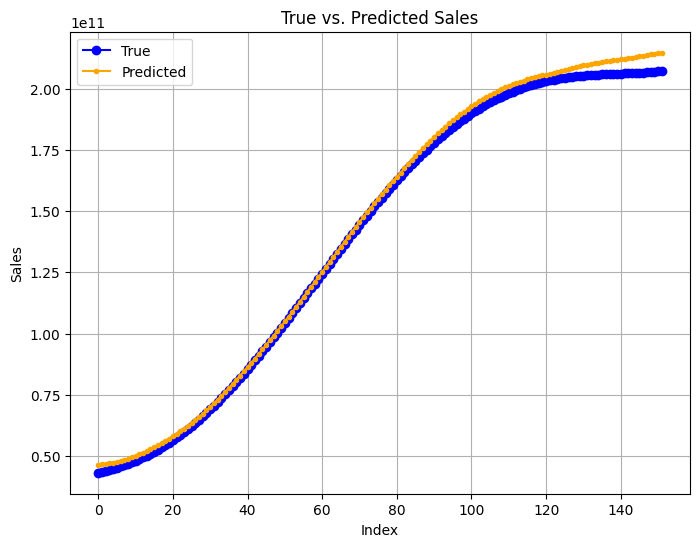

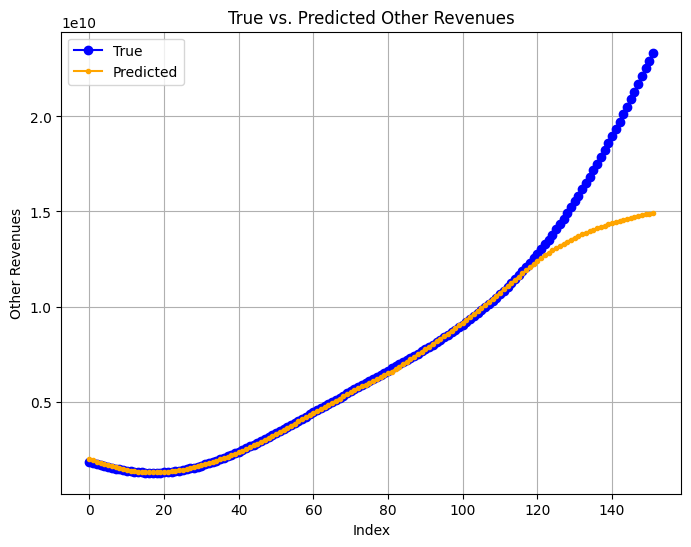

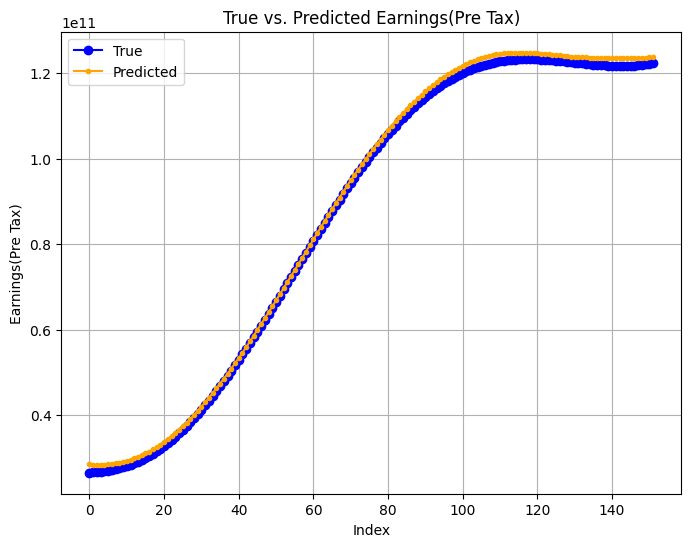

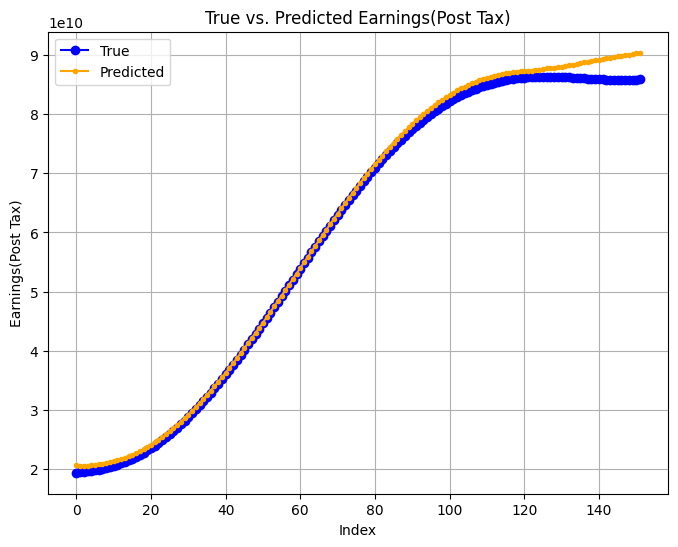

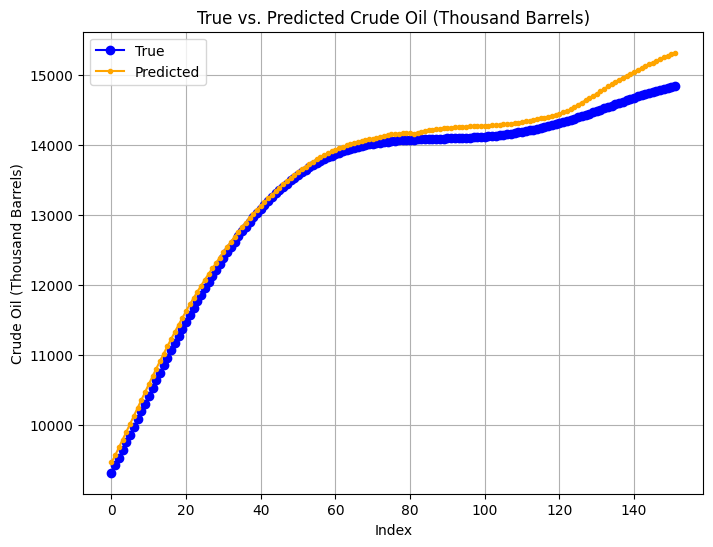

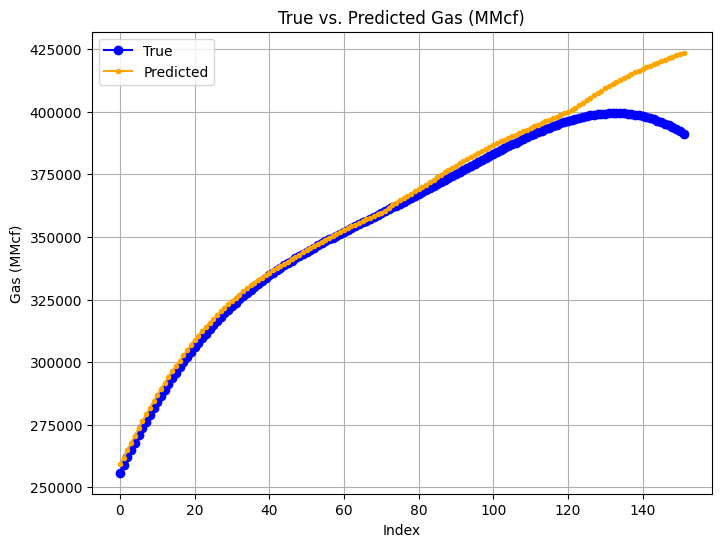

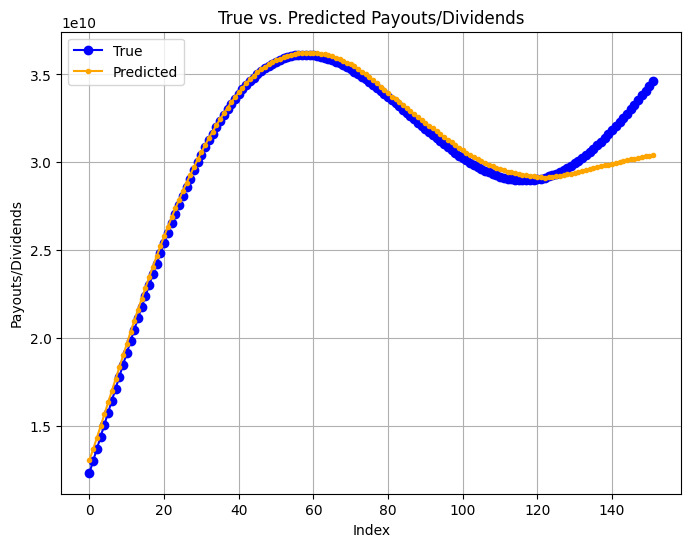

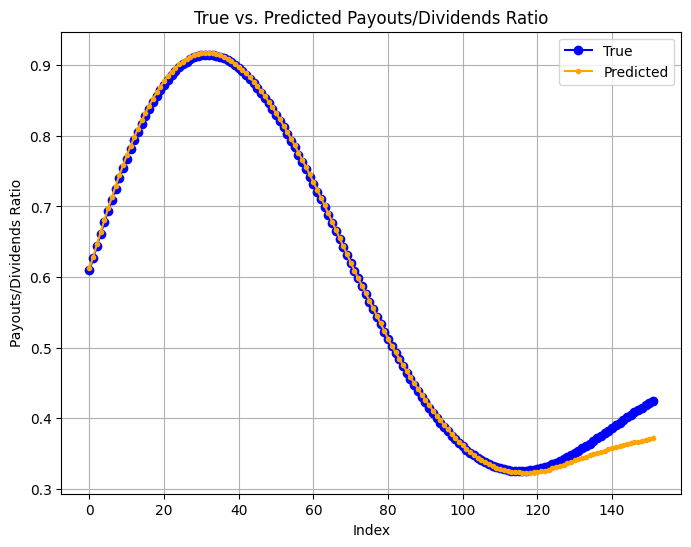

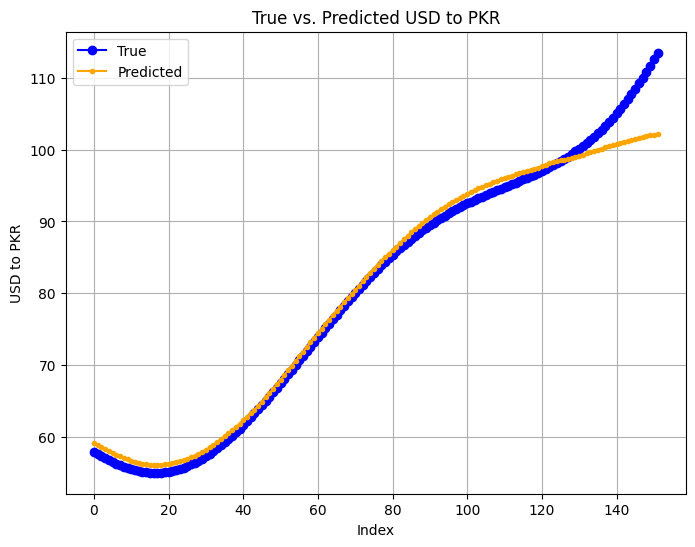

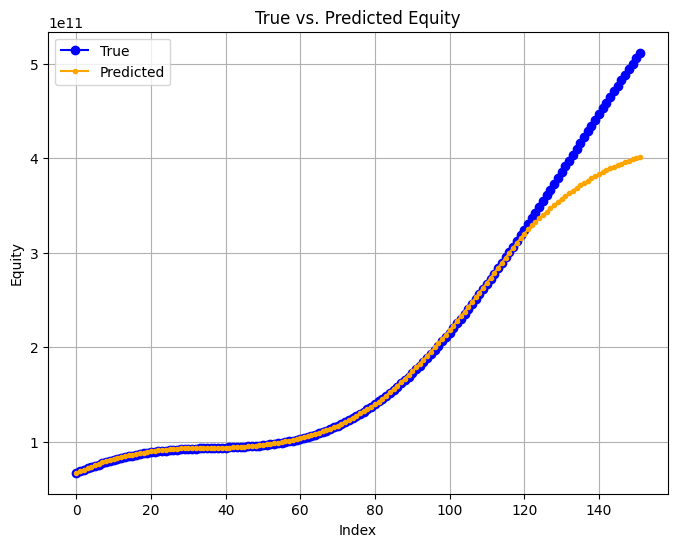

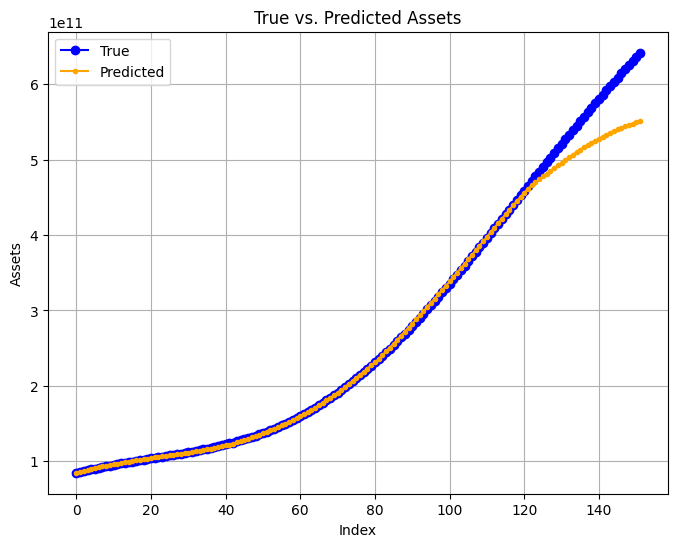

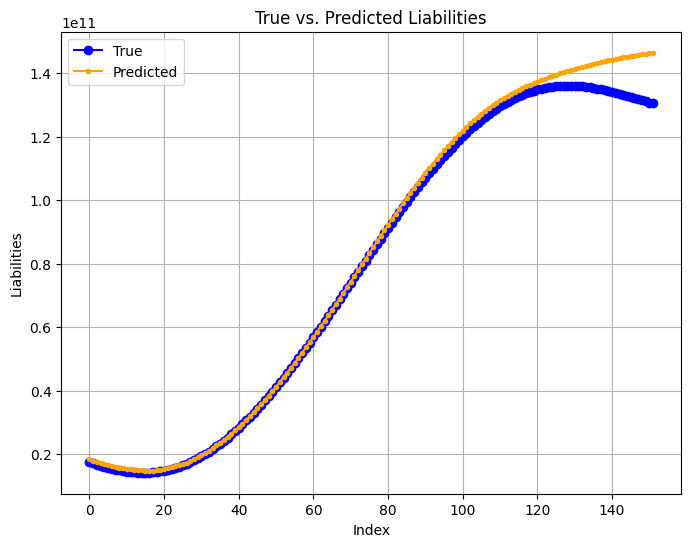

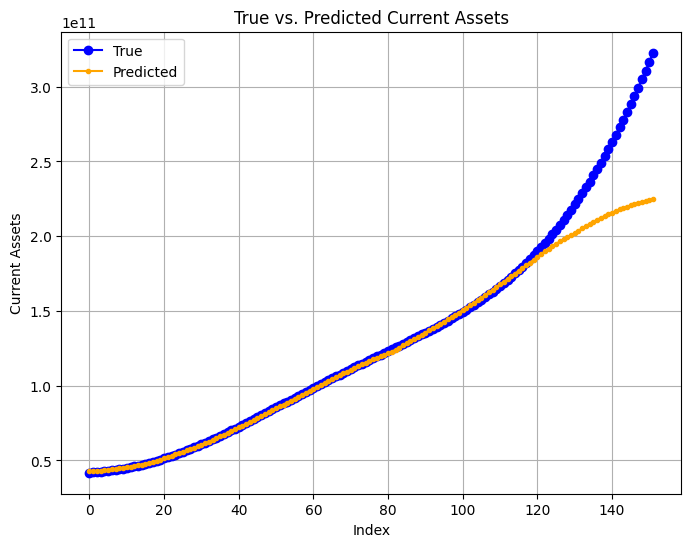

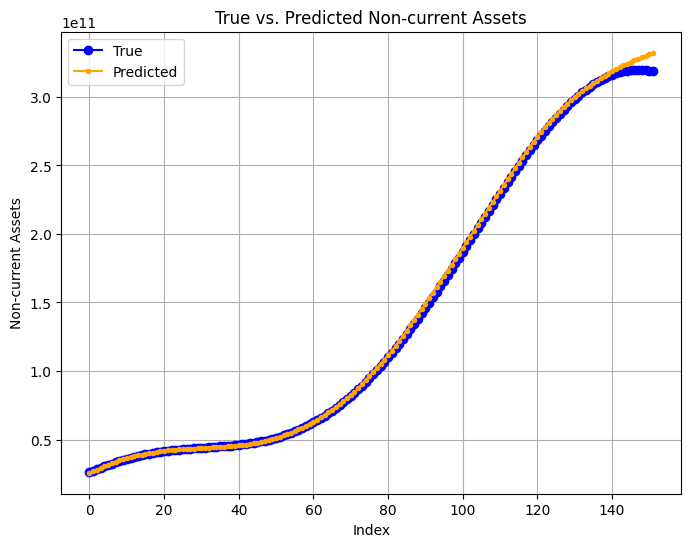

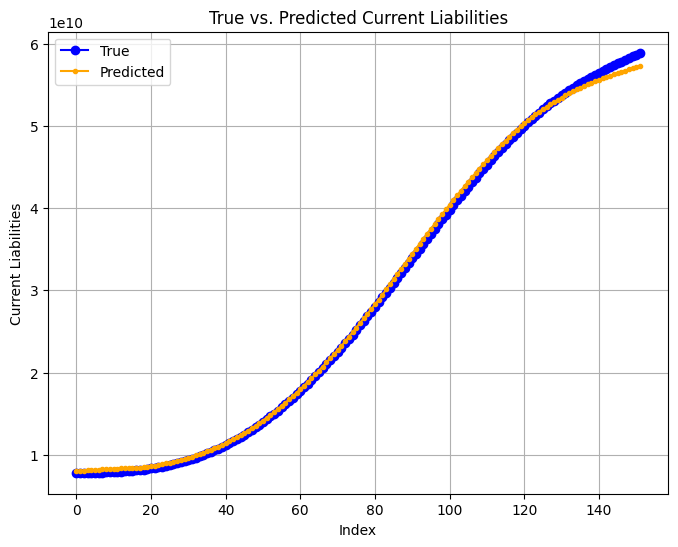

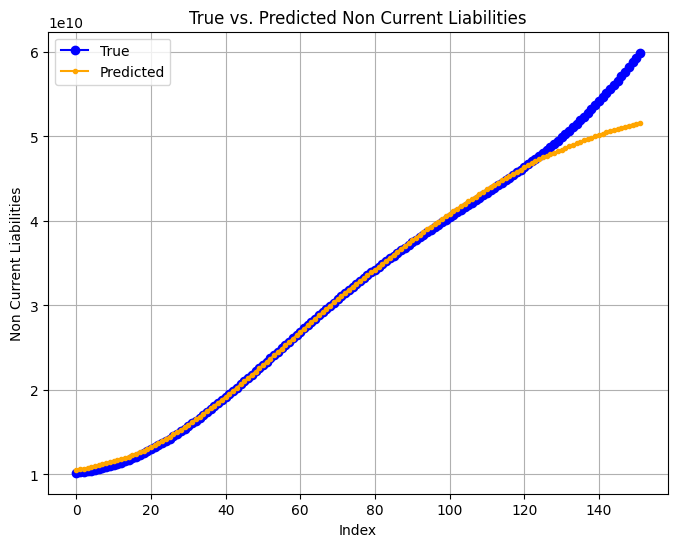

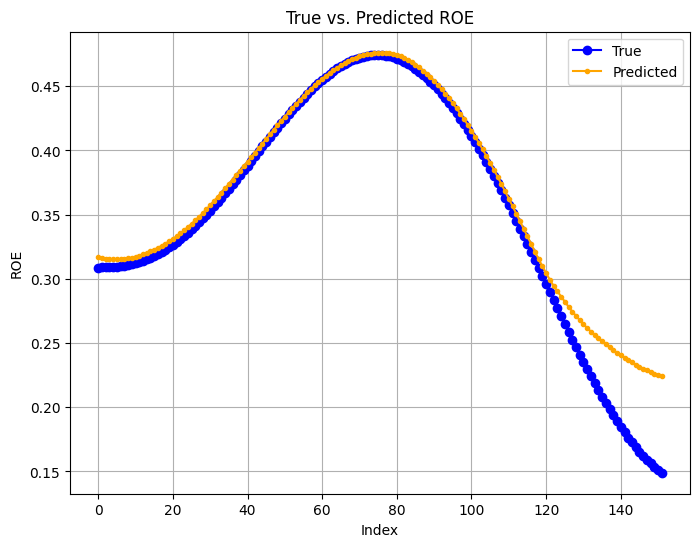

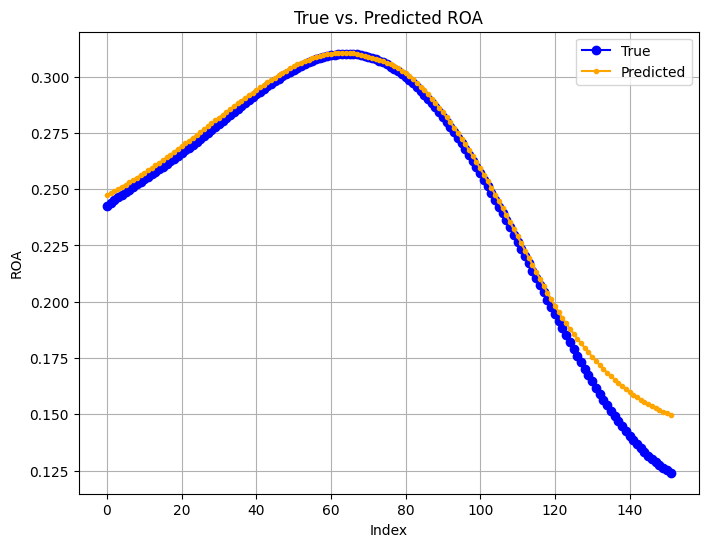

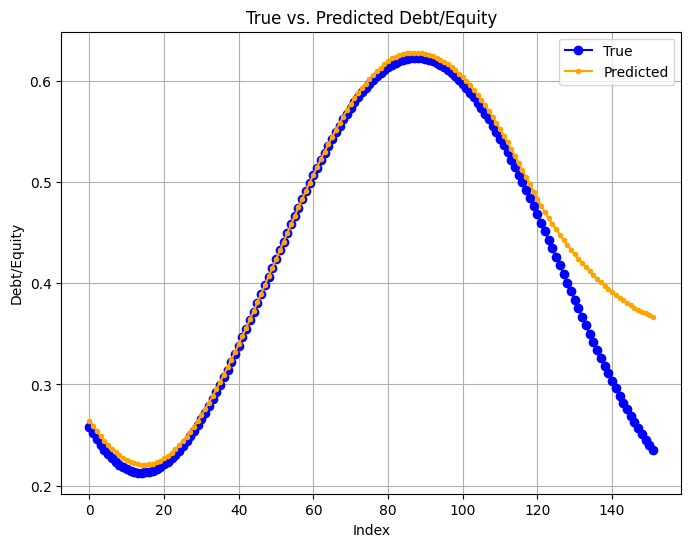

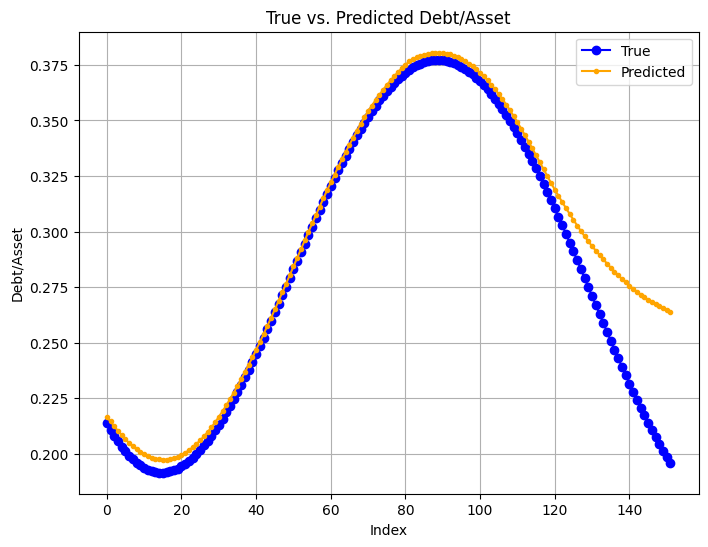

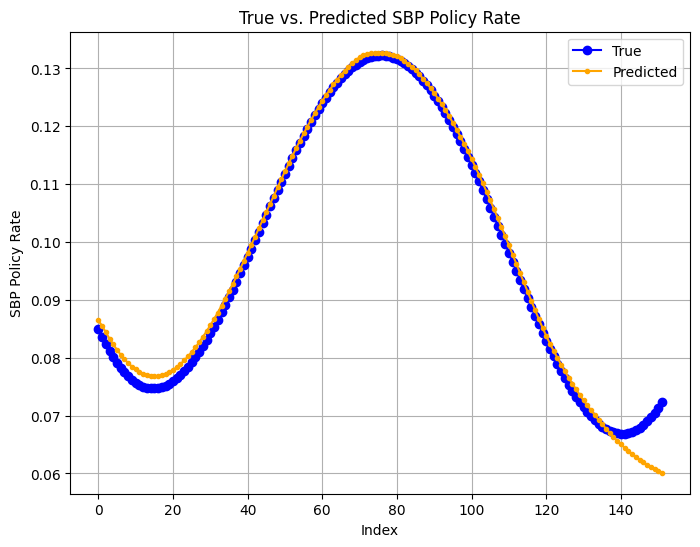

In [26]:
# Generate an index for plotting
plot_index = np.arange(len(y_train_downsampled))

# Loop through each feature and plot separately
for feature_index, column in enumerate(features.columns):
    # Create a new figure for each feature
    plt.figure(figsize=(8, 6))

    # Plot true values (downsampled)
    plt.plot(plot_index, y_train_downsampled_scaled[:, feature_index], label='True', linestyle='-', marker='o', color='blue')

    # Plot predictions
    plt.plot(plot_index, predictions_train_downsampled_scaled[:, feature_index], label='Predicted', linestyle='-', marker='.', color='orange')

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.title(f'True vs. Predicted {column}')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

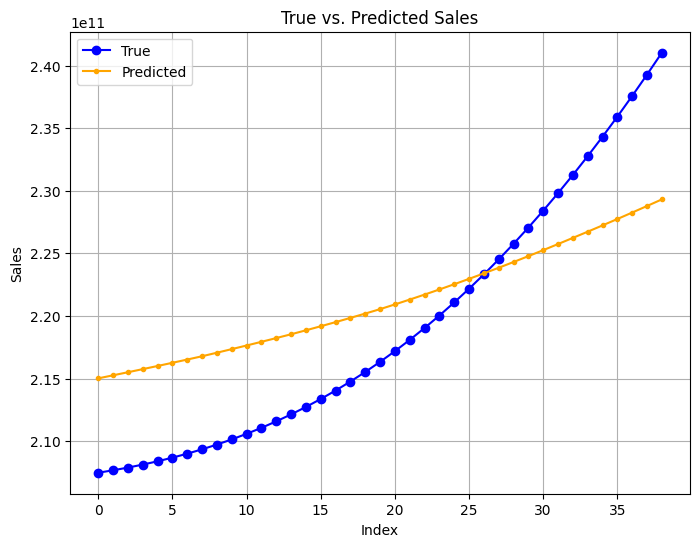

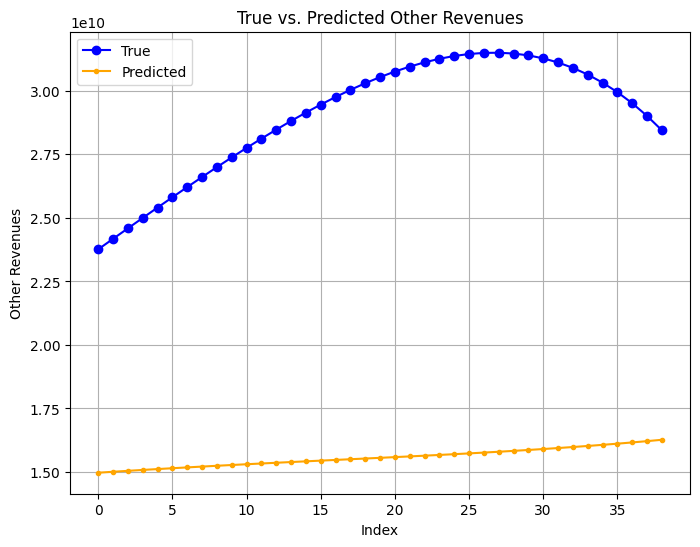

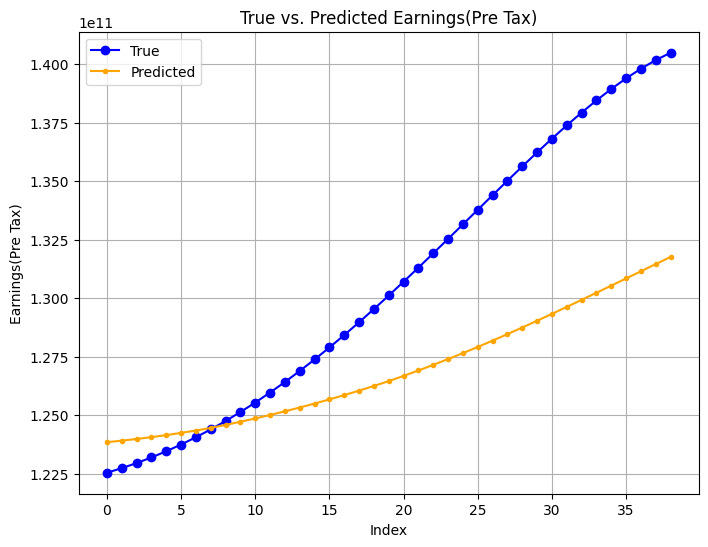

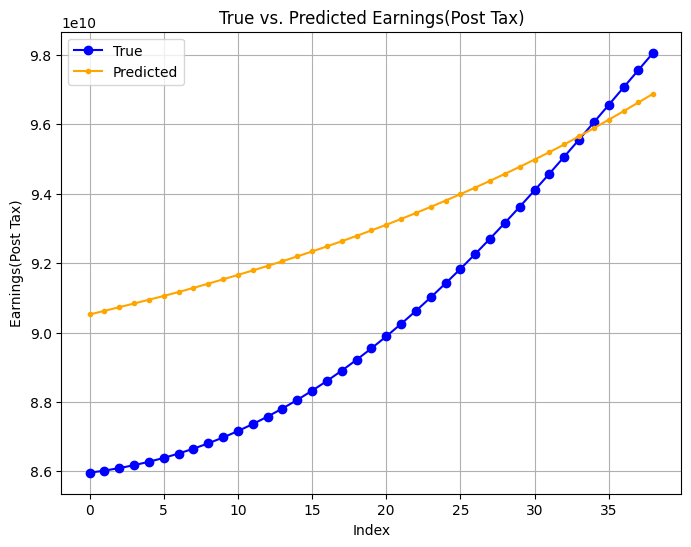

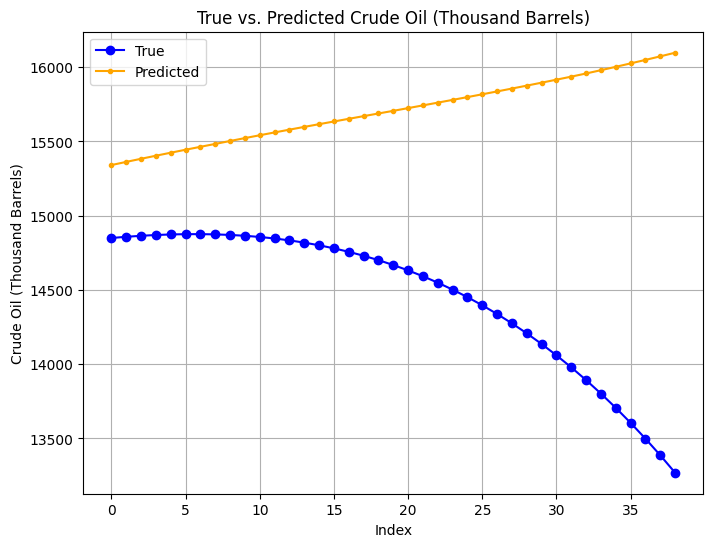

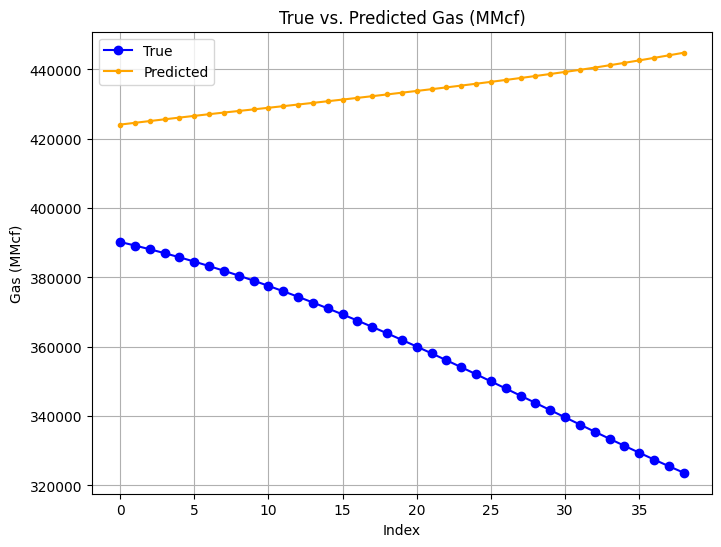

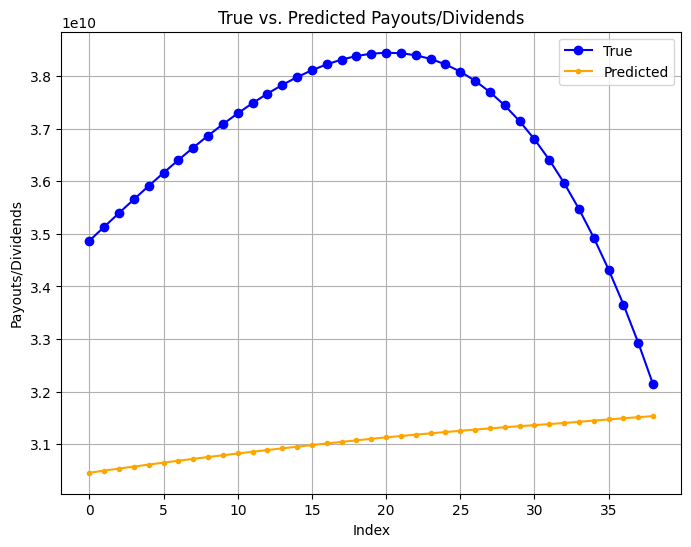

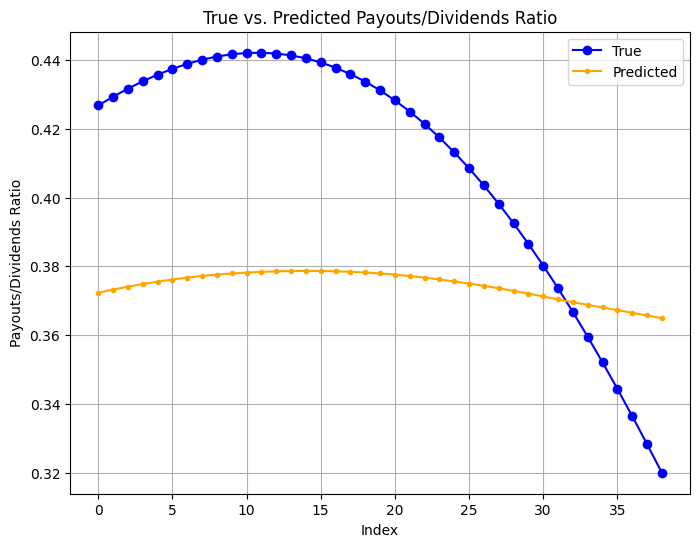

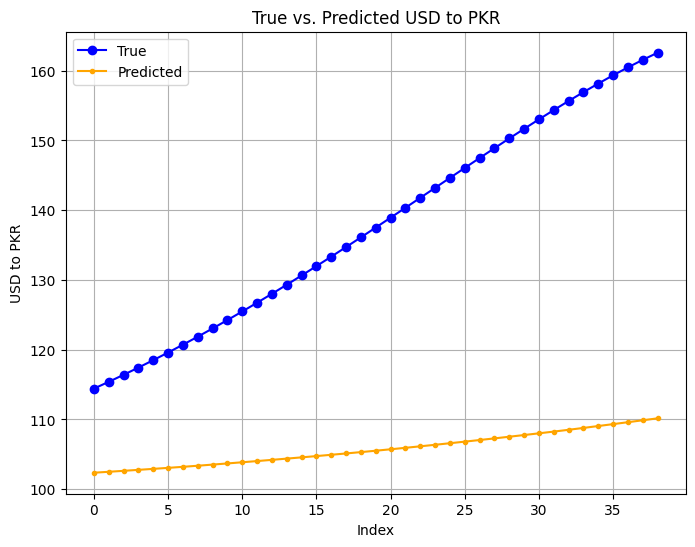

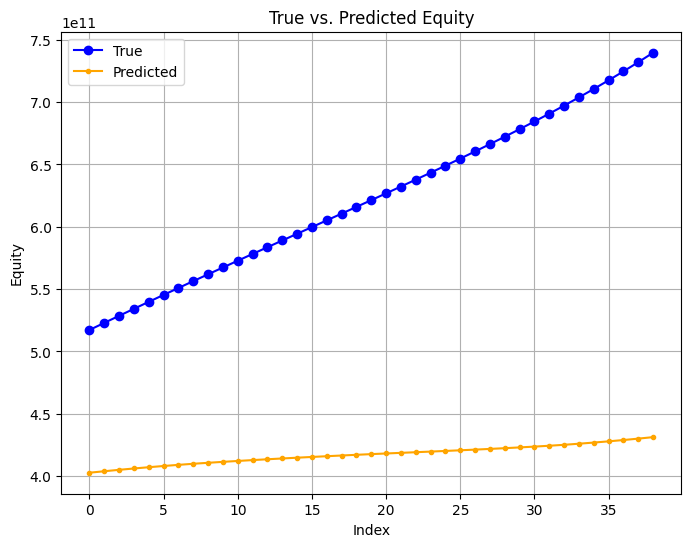

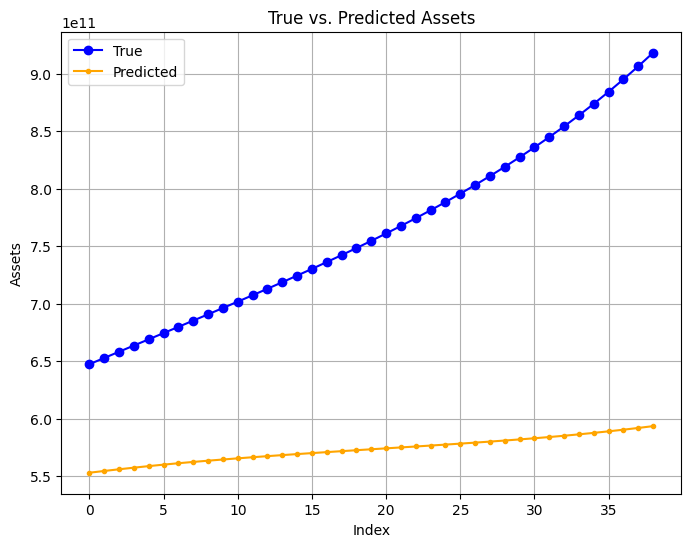

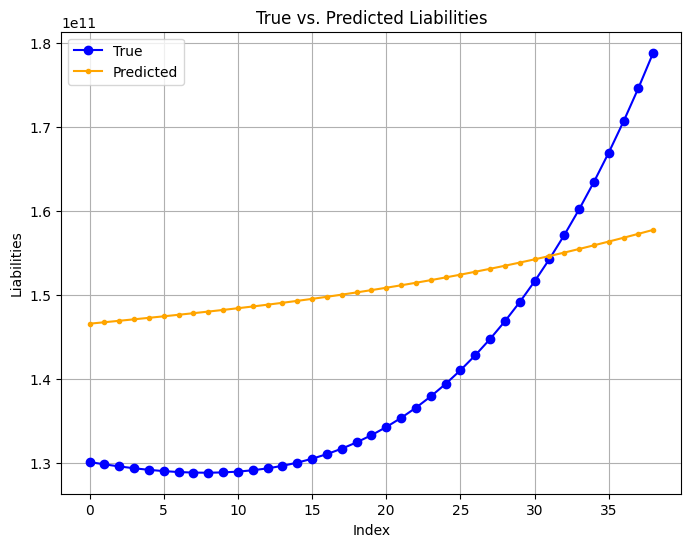

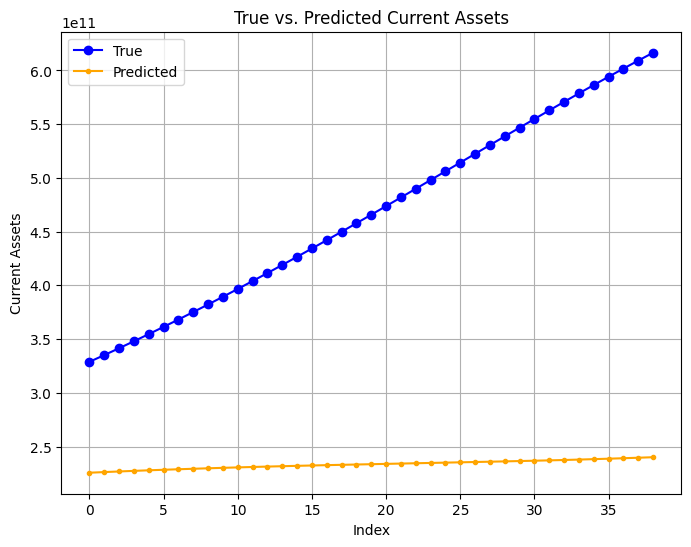

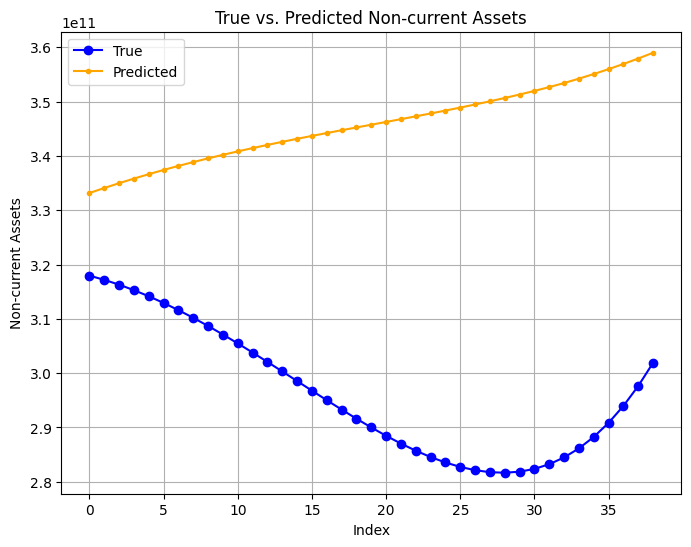

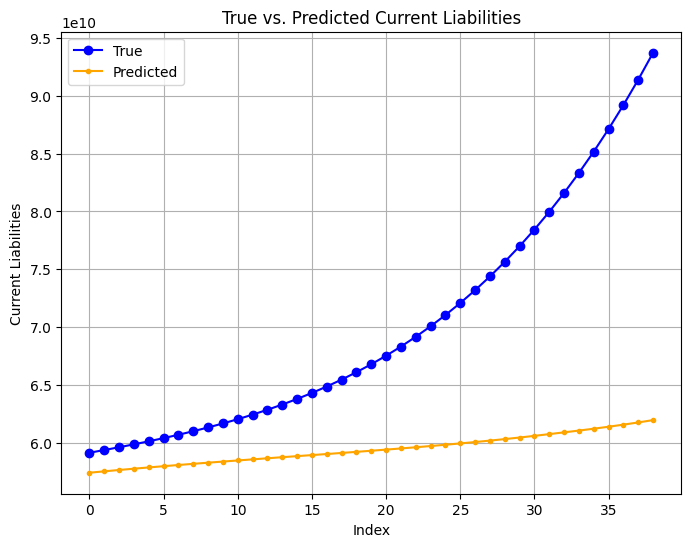

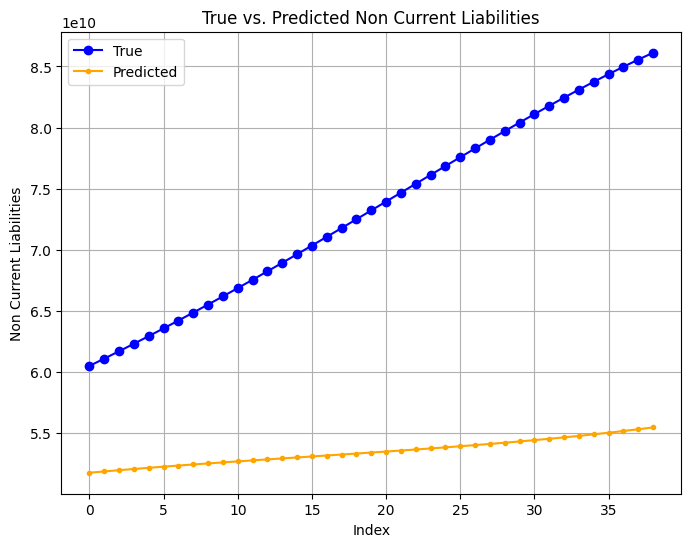

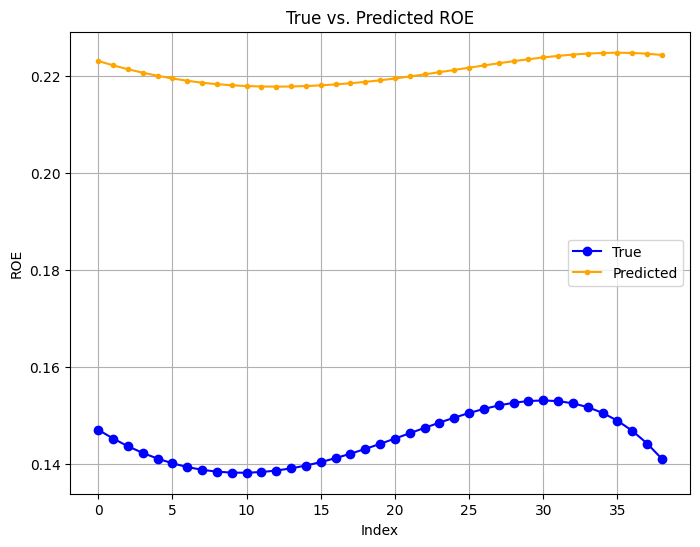

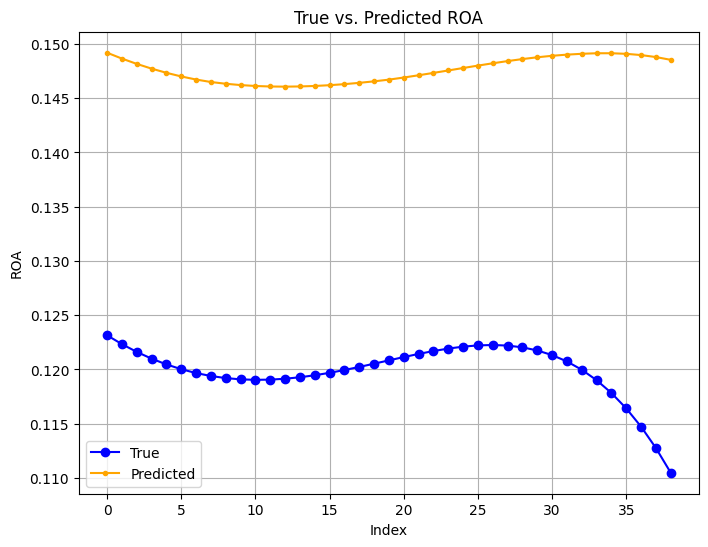

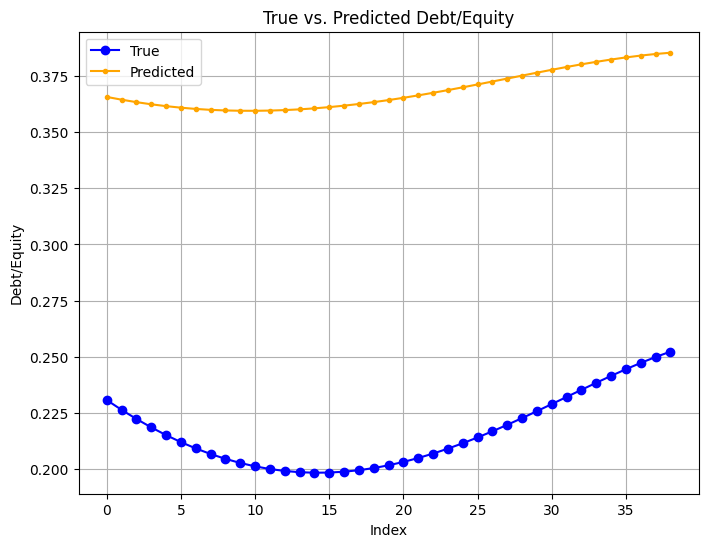

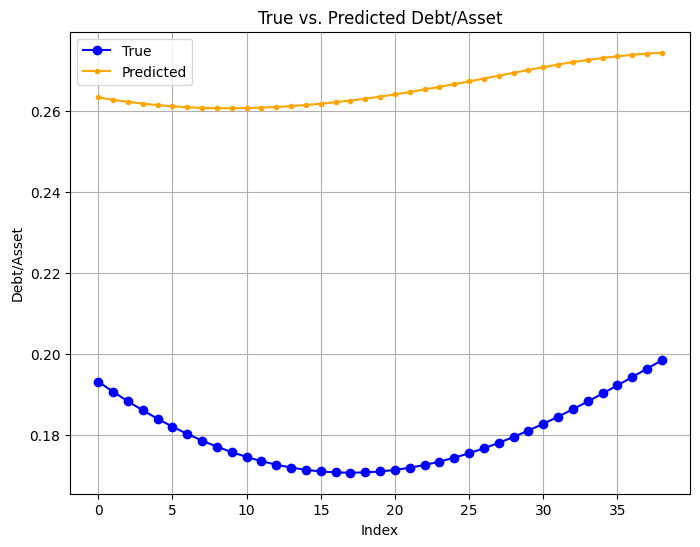

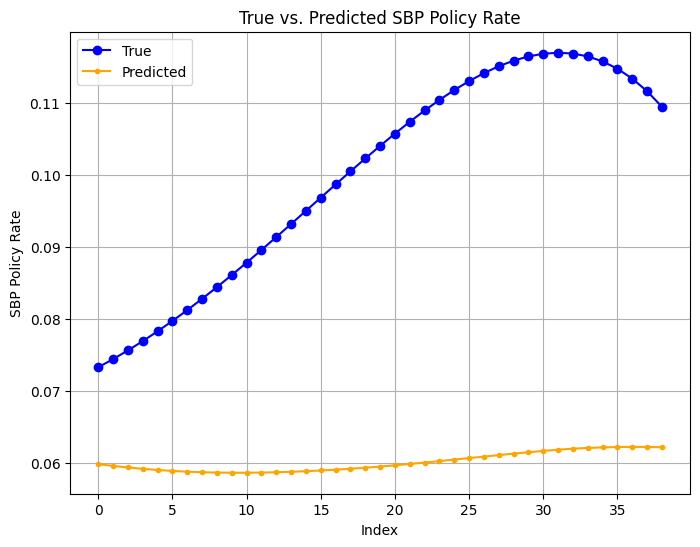

In [27]:
# Generate an index for plotting
plot_index = np.arange(len(y_test_downsampled))

# Loop through each feature and plot separately
for feature_index, column in enumerate(features.columns):
    # Create a new figure for each feature
    plt.figure(figsize=(8, 6))

    # Plot true values (downsampled)
    plt.plot(plot_index, y_test_downsampled_scaled[:, feature_index], label='True', linestyle='-', marker='o', color='blue')

    # Plot predictions
    plt.plot(plot_index, predictions_test_downsampled_scaled[:, feature_index], label='Predicted', linestyle='-', marker='.', color='orange')

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.title(f'True vs. Predicted {column}')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()